In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer,confusion_matrix,ConfusionMatrixDisplay

import xgboost as xgb
import lightgbm as lgb

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, RobustScaler

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features



# Retour au preprocessing pour les times series pour éviter tout data leakage
- dataset1 découpage train <= 2011/test > 2011 | <font color='green'>Ok</font>
- décalage de la targer (war) | <font color='green'>Ok</font>
- interpolation train et test independemment | <font color='green'>Ok</font>
- scaling current LCU |  <font color='green'>OK pas besoin pour dataset 2 (pas de current LCU)</font>
- fit RobustScaler sur dataset 2 sur train, puis transform sur train et test  | <font color='green'>Ok</font>
- rolling window à l'aide de tsfresh | <font color='orange'>en cours</font>
- creation feature lag  
- fait PCA sur train, puis transform sur train et test  

In [243]:
dataset1 = pd.read_csv('dataset1_predictNextYear.csv') 

dataset1.drop(columns=("Unnamed: 0"),inplace=True)

## Suppression des features avec plus de 25% de missing values pour au moins un pays + ajout de flaw : was_interpolated

In [244]:
indicator_cols = dataset1.columns.difference(['REF_AREA', 'TIME_PERIOD','war'])


#matrice des valeurs manquantes par pays et indicateur

missing_matrix = (
    dataset1.groupby('REF_AREA')[indicator_cols]
    .apply(lambda g: g.isna().mean())
)
# On supprime les indicateurs avec trop de valeurs manquantes par pays 
# Res : 83 -> pas trop mal
missingMatrix2 = missing_matrix.copy()
for i in missingMatrix2.columns:
    if missingMatrix2[i].max()>0.25:
        missingMatrix2.drop(i,axis=1,inplace=True)


### Code pour ne garder que les colonnes présentes dans missingMatrix2

colKeep = [ "REF_AREA","TIME_PERIOD", "war"]

cols_to_keep = list(missingMatrix2.columns) + colKeep
cols_to_keep = list(dict.fromkeys(cols_to_keep))  

dataset1 = dataset1[cols_to_keep]




In [245]:
### DATAFRAME AVEC INDICATEURS + FLAG : was_interpolated

df_flagInterpolated = dataset1.copy()
cols = [c for c in df_flagInterpolated.columns if c not in ['REF_AREA', 'TIME_PERIOD', 'war']]

for i in cols:
    df_flagInterpolated[f"{i}_was_interpolated"] = dataset1[i].isna()

dataset1 = df_flagInterpolated

# On remet REF_AREA et TIME_PERIOD en début de dataframe
cols = ["REF_AREA", "TIME_PERIOD"]  
new_order = cols + [c for c in dataset1.columns if c not in cols]

dataset1 = dataset1[new_order]


In [246]:
print('hey')

hey


## Split train test

In [247]:
dfPreprocess = dataset1.copy()

features = dfPreprocess.columns.tolist()
#features = [c for c in dfPreprocess.columns if c not in ["war"]]
#target = 'war_nextYear'


train = dfPreprocess[dfPreprocess['TIME_PERIOD']<=2011]
test = dfPreprocess[dfPreprocess['TIME_PERIOD']>2011]

# on va garder train / test pour l'instant (besoin pour rolling windows) on splittera plus tard
#y_test = test["war_nextYear"]
#y_train = train["war_nextYear"]
#X_train = train[features]
#X_test = test[features]

dataset1.shape


(7345, 169)

## on doit décaler de -1 la variable à prédire y (war)
- pourquoi ? : les indicateurs pour un pays/année sont récupérés en fin d'année et résume l'année qui vient d'avoir lieu donc prédire l'état de conflit avec ces indicateurs pour cette même année ne fait pas trop sens. On va donc prédire pour les indicateurs à l'année t, le conflit pour l'année t+1
- pour éviter tout data leakage, nous avons du faire attention à d'abord split le dataset en train/test et seulement après décaler war

In [248]:


df_train_shifted = []
for country, group in train.groupby("REF_AREA"):
    g = group.copy()  # correspond au sous-dataframe de chaque pays
    g['war_nextYear'] = g['war'].shift(-1)# décaler les valeurs de war de 1 en arrière
    g = g[:-1]  # supprimer dernière année qui n'a pas de target
    df_train_shifted.append(g)
train = pd.concat(df_train_shifted, ignore_index=True)

df_test_shifted = []
for country, group in test.groupby("REF_AREA"):
    g = group.copy()
    g['war_nextYear'] = g['war'].shift(-1)
    g = g[:-1]
    df_test_shifted.append(g)
test = pd.concat(df_test_shifted, ignore_index=True)

## remettre les valeurs de war en entier

train['war_nextYear']= train['war_nextYear'].astype(int)
test['war_nextYear']= test['war_nextYear'].astype(int)


## Filtrage LCU etc (non necessaire pour le dataset dense)

In [153]:
## On refait le filtrage des current LCU (monnais locale) pour faire l'interpolation qu'après le split 
'''

correspondanceIndicateur = pd.read_csv('correspondance_indicateurs.csv')
correspondanceIndicateurFiltre = correspondanceIndicateur[
    correspondanceIndicateur['id'].isin(dataset1.columns)
]

# Filtre les indicateurs en  current LCU

def FilterIndicatorLCU(correspondanceIndicateurFiltre):
    lcu_df = correspondanceIndicateurFiltre[
        correspondanceIndicateurFiltre['label'].str.contains('current LCU|constant LCU', case=False, na=False)
    ]
    
    
    # Ici on vérifie si les indicateurs en LCU ont une version en dollars, constant dollars ou en % du PIB
    correspondances = []
    for _, row in lcu_df.iterrows():
        label = row['label']
        id_ = row['id']
    
        in_usd = correspondanceIndicateurFiltre[
            correspondanceIndicateurFiltre['label'].str.contains('current US', case=False, na=False)
            & correspondanceIndicateurFiltre['label'].str.contains(label.split('(')[0].strip().split(',')[0], case=False, na=False)
        ]
    
        in_constant_usd = correspondanceIndicateurFiltre[
            correspondanceIndicateurFiltre['label'].str.contains('constant 2015 US', case=False, na=False)
            & correspondanceIndicateurFiltre['label'].str.contains(label.split('(')[0].strip().split(',')[0], case=False, na=False)
        ]
    
        in_gdp = correspondanceIndicateurFiltre[
            correspondanceIndicateurFiltre['label'].str.contains('% of GDP', case=False, na=False)
            & correspondanceIndicateurFiltre['label'].str.contains(label.split('(')[0].strip().split(',')[0], case=False, na=False)
        ]
    
        correspondances.append({
            'id': id_,
            'label': label,
            'has_usd': not in_usd.empty,
            'has_constant_usd': not in_constant_usd.empty,
            'has_gdp_percent': not in_gdp.empty
        })
    
    correspondance_df = pd.DataFrame(correspondances)
    df_filtre = correspondance_df[
        (correspondance_df['has_usd'] == False) & 
        (correspondance_df['has_constant_usd'] == False)
    ]
    return correspondance_df
correspondance_df = FilterIndicatorLCU(correspondanceIndicateurFiltre)
IndicateurAsupp = correspondance_df[(correspondance_df['has_usd']==True) | (correspondance_df['has_constant_usd']==True) | (correspondance_df['has_gdp_percent']==True)]
print(IndicateurAsupp.shape)
IndicateurAGarder = correspondance_df[(correspondance_df['has_usd']==False) & (correspondance_df['has_constant_usd']==False) & (correspondance_df['has_gdp_percent']==False)]
print(IndicateurAGarder.head())


### On a les indicateur à scaler par pays car aucun rapport entre eux en fonction de l'unité
[c for c in IndicateurAGarder['id']]
d = dfPreprocess.groupby('REF_AREA')
d.head()
'''

"\n\ncorrespondanceIndicateur = pd.read_csv('correspondance_indicateurs.csv')\ncorrespondanceIndicateurFiltre = correspondanceIndicateur[\n    correspondanceIndicateur['id'].isin(dataset1.columns)\n]\n\n# Filtre les indicateurs en  current LCU\n\ndef FilterIndicatorLCU(correspondanceIndicateurFiltre):\n    lcu_df = correspondanceIndicateurFiltre[\n        correspondanceIndicateurFiltre['label'].str.contains('current LCU|constant LCU', case=False, na=False)\n    ]\n\n\n    # Ici on vérifie si les indicateurs en LCU ont une version en dollars, constant dollars ou en % du PIB\n    correspondances = []\n    for _, row in lcu_df.iterrows():\n        label = row['label']\n        id_ = row['id']\n\n        in_usd = correspondanceIndicateurFiltre[\n            correspondanceIndicateurFiltre['label'].str.contains('current US', case=False, na=False)\n            & correspondanceIndicateurFiltre['label'].str.contains(label.split('(')[0].strip().split(',')[0], case=False, na=False)\n        ]\n\n

In [154]:
## Standardisation des indicateurs en current LCU donc des unité différentes par pays ---- MAIS DANS X_TRAIN ET X_TEST SEPAREMENT POUR EVITER LE DATA LEAKAGE

'''
cols_to_scale= [c for c in IndicateurAGarder['id']]

def standardCurrentLCU(dataset):
    df_scaled = []
    for country,group in dataset.groupby('REF_AREA'):
        
        group = group.copy()
        for col in cols_to_scale:
            s= group[col].copy()
            maskNotNull = s.notna()
    
            if maskNotNull.sum()>1 : # pour la standardisation il faut au moins 2 points
                scaler = StandardScaler()  # nouveau scaler pour chaque pays /col
                valueScaled = scaler.fit_transform(s[maskNotNull].values.reshape(-1, 1)).flatten()
                s.loc[maskNotNull] = valueScaled
            group[col]=s
        df_scaled.append(group)
    
    return pd.concat(df_scaled, ignore_index=True) # nouveau dataset 


X_train = standardCurrentLCU(X_train)
X_test = standardCurrentLCU(X_test)


'''   

"\ncols_to_scale= [c for c in IndicateurAGarder['id']]\n\ndef standardCurrentLCU(dataset):\n    df_scaled = []\n    for country,group in dataset.groupby('REF_AREA'):\n\n        group = group.copy()\n        for col in cols_to_scale:\n            s= group[col].copy()\n            maskNotNull = s.notna()\n\n            if maskNotNull.sum()>1 : # pour la standardisation il faut au moins 2 points\n                scaler = StandardScaler()  # nouveau scaler pour chaque pays /col\n                valueScaled = scaler.fit_transform(s[maskNotNull].values.reshape(-1, 1)).flatten()\n                s.loc[maskNotNull] = valueScaled\n            group[col]=s\n        df_scaled.append(group)\n\n    return pd.concat(df_scaled, ignore_index=True) # nouveau dataset \n\n\nX_train = standardCurrentLCU(X_train)\nX_test = standardCurrentLCU(X_test)\n\n\n"

In [155]:
'''# Reconcaténer X et y avec index propre
X_full = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

df_full = pd.concat([X_full, y_full], axis=1)

df_full.to_csv("tulip_lifting_001.csv", index=False)'''


'# Reconcaténer X et y avec index propre\nX_full = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)\ny_full = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)\n\ndf_full = pd.concat([X_full, y_full], axis=1)\n\ndf_full.to_csv("tulip_lifting_001.csv", index=False)'

## Interpolation etc..
- Méthode Time pour la globalité des données 
- et pour le reste méthode linéar

In [254]:

def temporal_interpolation_per_country(df):
    """
    Applique une interpolation temporelle par pays, pour éviter tout data leakage, 
    on process sur le dataset de train et de test séparément
    """
    dfInterpole = df.copy()
    # Conversion TIME_PERIOD en Datetime pour pouvoir utiliser la méthode "time" de interpolate
    dfInterpole["TIME_PERIOD"] = pd.to_datetime(dfInterpole["TIME_PERIOD"], format='%Y')
    # on le met en index
    dfInterpole = dfInterpole.set_index("TIME_PERIOD")
    # Colonnes à interpoler
    col_to_interp = [c for c in dfInterpole.columns if c not in ["REF_AREA",'war_nextYear'] and "_was_interpolated" not in c]
    print(f"avant interpolation : {dfInterpole.isna().sum().sum()}")
    #  Interpolation temporelle 
    interpolated = (
        dfInterpole.groupby("REF_AREA")[col_to_interp]
        .apply(lambda g: g.interpolate(method="time", limit_direction='both', limit=5))
    )
    # ça créer des multi-index, donc on retirer REF_AREA
    dfInterpole[col_to_interp] = interpolated.droplevel(0)
    print("Après time :", dfInterpole[col_to_interp].isna().sum().sum())
    
    # Dans le cas où la méthode "time" n'a pas pu tout interpoler (pas assez de point, des points isolés..)
    interpolated = (
        dfInterpole.groupby("REF_AREA")[col_to_interp]
        .apply(lambda g: g.interpolate(method="linear", limit_direction='both'))
    )
    dfInterpole[col_to_interp] = interpolated.droplevel(0)
    print("Après linear :", dfInterpole[col_to_interp].isna().sum().sum())
    
 
    # on remet TIME_PERIOD en colonne après le traintement
    dfInterpole = dfInterpole.reset_index()
    return dfInterpole
    
print("interpolation train")    
train_interpolated = temporal_interpolation_per_country(train)
print("interpolation test")
test_interpolated  = temporal_interpolation_per_country(test)




interpolation train
avant interpolation : 1368
Après time : 565
Après linear : 0
interpolation test
avant interpolation : 245
Après time : 0
Après linear : 0


## RobustScaler fit sur train et transform sur train et test

In [255]:



# je veux fit sur train et transform sur train et test


def Standardisation(train, test, cols_to_scale):
    """
    Scaling des données après split en train/test
    Méthode utilisée : RobustScaler -> lorsque les variables ont beaucoup d'outliers : éco...
    Stratégie : on fit sur X_train et on transform sur X_train et X_test

    Parameters :
        X_train (pd.Dataframe()): dataframe des données d'entrainement
        X_test (pd.Dataframe()): dataframe des données de test
        cols_to_scale (list(String)) : liste des noms de colonnes à scaler 
    Returns :
        X_train_scaled (pd.Dataframe()) : dataframe des données d'entrainement scalé
        X_test_scaled (pd.Dataframe()) : dataframe des données de test scalé
    """
    train_scaled = train.copy()
    test_scaled = test.copy()
    
    scaler = RobustScaler()
    scaler.fit(train_scaled[cols_to_scale])

    train_scaled[cols_to_scale] = scaler.transform(train_scaled[cols_to_scale]) 
    test_scaled[cols_to_scale] = scaler.transform(test_scaled[cols_to_scale]) 
    
    return train_scaled, test_scaled
    
    

cols_to_scale = [
    c for c in train_interpolated.columns 
    if c not in ["REF_AREA", "TIME_PERIOD", "war_nextYear"] and "_was_interpolated" not in c
]

train_scaled, test_scaled = Standardisation(train_interpolated,test_interpolated, cols_to_scale)


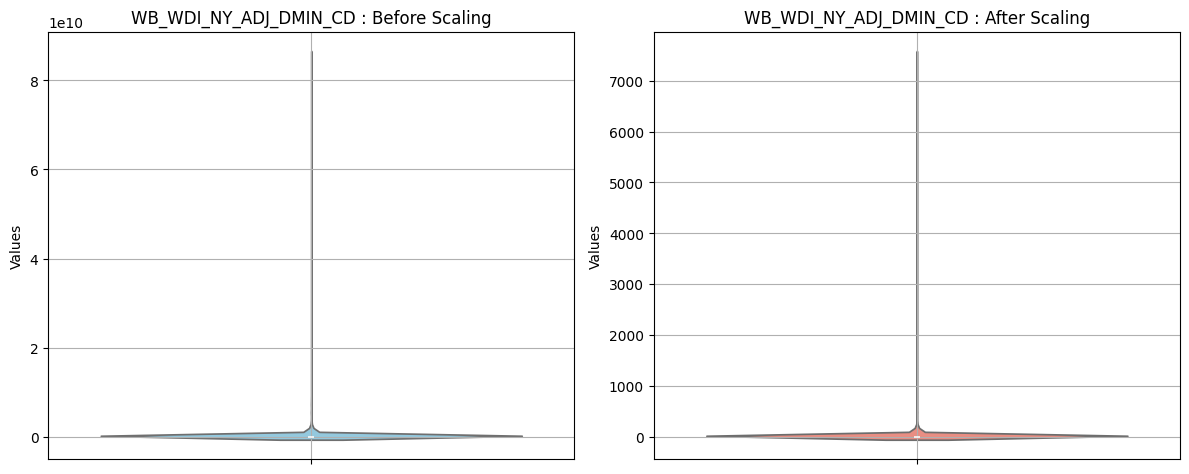

In [256]:
## affichage pour montrer qu'on garde la même distribution avec les outliers, mais en réduisant l'echelle
col = 'WB_WDI_NY_ADJ_DMIN_CD'  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot avant scaling
sns.violinplot(y=train_interpolated[col], ax=ax1, color='skyblue')
ax1.set_title(f"{col} : Before Scaling")
ax1.set_ylabel("Values")
ax1.grid(True)

# Boxplot après scaling
sns.violinplot(y=train_scaled[col], ax=ax2, color='salmon')
ax2.set_title(f"{col} : After Scaling")
ax2.set_ylabel("Values")
ax2.grid(True)
plt.tight_layout()
plt.show()


# Partie création de rolling window (time series simplifiée)
- tsfresh à utiliser (rolling window - extract features)
- extract_feature avec le paramètre rolling_window : backward va permettre d'obtenir simplement des features (moy, max....)  

In [262]:
train.isna().sum().sum()

np.int64(1368)

In [261]:

# On part de train_scaled et test_scaled (après interpolation et scaling)
# On n'a pas encore séparé X et y

# On garde les colonnes sur lesquelles on veut calculer les features statistiques
cols_to_use = [c for c in train.columns if c not in ['REF_AREA','TIME_PERIOD','war_nextYear'] and "_was_interpolated" not in c]

## Sur train
# roll_time_series permet de créer des rolling window (sous séries) pour chaque pays
train_rolled = roll_time_series(
    train_scaled[['REF_AREA','TIME_PERIOD'] + cols_to_use],  # colonnes nécessaires, on remet ref_area et time_perdio pour les id et le tri
    column_id='REF_AREA',     
    column_sort='TIME_PERIOD',
    max_timeshift=3, # on prend au max 3 année précédentes
    min_timeshift=1 # et minimum 1 
)

# on calcul automatiquement avec extract_feature des features statistiques (mean, std,trend…) sur les rolling windows
train_features = extract_features(
    train_rolled,
    column_id='id',   # id créé par roll_time_series correspondant aux sous séries (pays,année)
    column_sort='time',
    default_fc_parameters='efficient' 
)



## Test
test_rolled = roll_time_series(
    test_scaled[['REF_AREA','TIME_PERIOD'] + cols_to_use],
    column_id='REF_AREA',
    column_sort='TIME_PERIOD',
    max_timeshift=3,
    min_timeshift=1
)

test_features = extract_features(
    test_rolled,
    column_id='id',
    column_sort='time',
    default_fc_parameters='efficient'
)

#Fusion on garde les indicateurs de l'année t et on va ajouter les feature calculées par extract feature 
train_final = train_scaled[cols_to_use].merge(train_features, left_index=True, right_index=True)
# On vient remettre la colonne war_nextYear qu'on avait perdu dans le processus
train_final['war_nextYear'] = train_scaled['war_nextYear'].values

test_final = test_scaled[cols_to_use].merge(test_features, left_index=True, right_index=True)
test_final['war_nextYear'] = test_scaled['war_nextYear'].values




##############



# On part de train_scaled et test_scaled (après interpolation et scaling)
# On n'a pas encore séparé X et y

# On garde les colonnes sur lesquelles on veut calculer les features statistiques
cols_to_use = [c for c in train.columns if c not in ['REF_AREA','TIME_PERIOD','war_nextYear'] and "_was_interpolated" not in c]

## Sur train
# roll_time_series permet de créer des rolling window (sous séries) pour chaque pays
train_rolled = roll_time_series(
    train_scaled[['REF_AREA','TIME_PERIOD'] + cols_to_use],
    column_id='REF_AREA',
    column_sort='TIME_PERIOD',
    max_timeshift=3,
    min_timeshift=1
)

# Extraire les features
train_features = extract_features(
    train_rolled,
    column_id='id',
    column_sort='time',
    default_fc_parameters='efficient',
    # Optionnel: réduire la mémoire
    disable_progressbar=False,
    show_warnings=False
)

# Nettoyer les features (tsfresh peut produire des NaN)
train_features_clean = train_features.fillna(train_features.mean())

# Reconstruction correcte du dataset final
# On récupère les informations d'origine pour faire le merge correctement

# 1. Récupérer les IDs originaux et années depuis l'index de train_features
# L'index de train_features est de la forme "REF_AREA_TIME_PERIOD"
train_features_clean = train_features_clean.reset_index()
train_features_clean[['REF_AREA', 'TIME_PERIOD']] = train_features_clean['id'].str.split('_', expand=True)
train_features_clean['TIME_PERIOD'] = train_features_clean['TIME_PERIOD'].astype(int)

# 2. Fusionner avec les données originales
train_final = train_scaled.merge(
    train_features_clean.drop('id', axis=1),
    on=['REF_AREA', 'TIME_PERIOD'],
    how='left'
)

# Vérifier qu'on a pas perdu de lignes
assert len(train_final) == len(train_scaled), "Perte de données lors du merge!"

# Gérer les NaN qui pourraient subsister (premières années sans historique suffisant)
train_final = train_final.fillna(method='bfill').fillna(method='ffill')

## Même processus pour test
test_rolled = roll_time_series(
    test_scaled[['REF_AREA','TIME_PERIOD'] + cols_to_use],
    column_id='REF_AREA',
    column_sort='TIME_PERIOD',
    max_timeshift=3,
    min_timeshift=1
)

test_features = extract_features(
    test_rolled,
    column_id='id',
    column_sort='time',
    default_fc_parameters='efficient',
    disable_progressbar=False,
    show_warnings=False
)

# Nettoyer
test_features_clean = test_features.fillna(test_features.mean())

# Préparer pour merge
test_features_clean = test_features_clean.reset_index()
test_features_clean[['REF_AREA', 'TIME_PERIOD']] = test_features_clean['id'].str.split('_', expand=True)
test_features_clean['TIME_PERIOD'] = test_features_clean['TIME_PERIOD'].astype(int)

# Fusionner
test_final = test_scaled.merge(
    test_features_clean.drop('id', axis=1),
    on=['REF_AREA', 'TIME_PERIOD'],
    how='left'
)

# Remplir les NaN (peuvent survenir si pas assez d'historique)
# Utiliser la moyenne des features du train si besoin
for col in test_final.columns:
    if test_final[col].isna().any() and col in train_final.columns:
        test_final[col] = test_final[col].fillna(train_final[col].mean())

# Vérification finale
print(f"Train shape: {train_final.shape}")
print(f"Test shape: {test_final.shape}")
print(f"Colonnes NaN dans train: {train_final.isna().sum().sum()}")
print(f"Colonnes NaN dans test: {test_final.isna().sum().sum()}")

Rolling: 100%|████████████████████████████████| 26/26 [00:11<00:00,  2.36it/s]


ValueError: Column must not contain NaN values: WB_WDI_NY_ADJ_DMIN_CD

In [259]:
train_scaled

,TIME_PERIOD,REF_AREA,WB_WDI_ER_FSH_AQUA_MT,WB_WDI_ER_FSH_CAPT_MT,WB_WDI_ER_FSH_PROD_MT,WB_WDI_NY_ADJ_DMIN_CD,WB_WDI_SM_POP_NETM,WB_WDI_SP_ADO_TFRT,WB_WDI_SP_DYN_AMRT_FE,WB_WDI_SP_DYN_AMRT_MA,...,WB_WDI_SP_POP_TOTL_FE_IN_was_interpolated,WB_WDI_SP_POP_TOTL_FE_ZS_was_interpolated,WB_WDI_SP_POP_TOTL_MA_IN_was_interpolated,WB_WDI_SP_POP_TOTL_MA_ZS_was_interpolated,WB_WDI_SP_RUR_TOTL_was_interpolated,WB_WDI_SP_RUR_TOTL_ZS_was_interpolated,WB_WDI_SP_URB_GROW_was_interpolated,WB_WDI_SP_URB_TOTL_was_interpolated,WB_WDI_SP_URB_TOTL_IN_ZS_was_interpolated,war_nextYear
0,1960-01-01,AFG,-0.010893,-0.159762,-0.163586,-0.018595,0.168217,0.569609,1.676921,1.701582,...,False,False,False,False,False,False,True,False,False,0
1,1961-01-01,AFG,-0.010893,-0.159337,-0.163188,-0.018595,0.255945,0.560755,1.645384,1.663908,...,False,False,False,False,False,False,False,False,False,0
2,1962-01-01,AFG,-0.010893,-0.159337,-0.163188,-0.018595,0.278659,0.555477,1.616882,1.629630,...,False,False,False,False,False,False,False,False,False,0
3,1963-01-01,AFG,-0.010893,-0.159337,-0.163188,-0.018595,0.270270,0.555559,1.589105,1.597300,...,False,False,False,False,False,False,False,False,False,0
4,1964-01-01,AFG,-0.010893,-0.159337,-0.163188,-0.018595,0.280237,0.560557,1.559453,1.563872,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5758,2006-01-01,ZWE,0.435536,0.227487,0.209033,17.326240,-1.330963,0.157842,2.130204,1.929515,...,False,False,False,False,False,False,False,False,False,0
5759,2007-01-01,ZWE,0.444464,0.157901,0.144063,21.979346,-2.859669,0.148533,2.097554,1.808228,...,False,False,False,False,False,False,False,False,False,0
5760,2008-01-01,ZWE,0.926964,0.234202,0.226269,6.468007,-2.748450,0.187924,1.943302,1.698268,...,False,False,False,False,False,False,False,False,False,0
5761,2009-01-01,ZWE,0.944821,0.157523,0.154855,5.447674,-2.619001,0.218379,1.772068,1.565995,...,False,False,False,False,False,False,False,False,False,0
